In [2]:
from google.colab import files
files.upload()  # Upload your kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nadaemad11","key":"db5be32d70dfaeb99d6dfca75544eebf"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#Download the Spotify dataset from Kaggle
!kaggle datasets download -d vatsalmavani/spotify-dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/vatsalmavani/spotify-dataset
License(s): unknown
  0% 0.00/16.5M [00:00<?, ?B/s]
100% 16.5M/16.5M [00:00<00:00, 1.64GB/s]


In [5]:

!pip install --quiet sentence-transformers faiss-cpu ipywidgets==7.7.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.5 MB/s eta 0:00:00


In [6]:
# ===============================================
# Import
# ===============================================
import pandas as pd
import numpy as np
import ast
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import ipywidgets as widgets
from IPython.display import display
from wordcloud import WordCloud
plt.style.use("ggplot")
import warnings
warnings.filterwarnings("ignore")

In [7]:
# ===============================================
# 1️. LOAD DATA
# ===============================================
DATA_DIR = Path("data")

files = {
    "tracks": DATA_DIR / "data.csv",
    "by_artist": DATA_DIR / "data_by_artist.csv",
    "by_genres": DATA_DIR / "data_by_genres.csv",
    "by_year": DATA_DIR / "data_by_year.csv",
    "w_genres": DATA_DIR / "data_w_genres.csv",
}

dfs = {}
for name, path in files.items():
    if path.exists():
        dfs[name] = pd.read_csv(path)
        print(f"{name} loaded successfully → shape = {dfs[name].shape}")
    else:
        print(f"{name} NOT FOUND at {path}")

tracks = dfs["tracks"]

tracks loaded successfully → shape = (170653, 19)
by_artist loaded successfully → shape = (28680, 15)
by_genres loaded successfully → shape = (2973, 14)
by_year loaded successfully → shape = (100, 14)
w_genres loaded successfully → shape = (28680, 16)


In [8]:
# ===============================================
# 2. Explore a CSV file
# ===============================================
def explore_csv(df, name="DataFrame"):
    print(f"\n=== {name} SAMPLE ===")
    display(df.head())

    print(f"\n=== {name} INFO ===")
    print(df.info())

    print(f"\n=== {name} SHAPE ===")
    print(df.shape)

    print(f"\n=== Missing Values ===")
    print(df.isnull().sum())

    print(f"\n=== Basic Stats ===")
    display(df.describe(include='all').T)

    print(f"\n=== Column Types ===")
    print(df.dtypes)

    # Unique values per column (optional for small datasets)
    for col in df.columns:
        if df[col].nunique() < 20:
            print(f"\nUnique values in '{col}': {df[col].unique()}")


In [9]:
# ===============================================
# Explore data.csv (tracks)
# ===============================================
explore_csv(dfs['tracks'], name="Tracks (data.csv)")



=== Tracks (data.csv) SAMPLE ===


,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665



=== Tracks (data.csv) INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  i

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
valence,170653.0,NaN,NaN,NaN,0.528587,0.263171,0.0,0.317,0.54,0.747,1.0
year,170653.0,NaN,NaN,NaN,1976.787241,25.917853,1921.0,1956.0,1977.0,1999.0,2020.0
acousticness,170653.0,NaN,NaN,NaN,0.502115,0.376032,0.0,0.102,0.516,0.893,0.996
artists,170653,34088,['Эрнест Хемингуэй'],1211,NaN,NaN,NaN,NaN,NaN,NaN,NaN
danceability,170653.0,NaN,NaN,NaN,0.537396,0.176138,0.0,0.415,0.548,0.668,0.988
duration_ms,170653.0,NaN,NaN,NaN,230948.310666,126118.414668,5108.0,169827.0,207467.0,262400.0,5403500.0
energy,170653.0,NaN,NaN,NaN,0.482389,0.267646,0.0,0.255,0.471,0.703,1.0
explicit,170653.0,NaN,NaN,NaN,0.084575,0.278249,0.0,0.0,0.0,0.0,1.0
id,170653,170653,7HmnJHfs0BkFzX4x8j0hkl,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
instrumentalness,170653.0,NaN,NaN,NaN,0.16701,0.313475,0.0,0.0,0.000216,0.102,1.0



=== Column Types ===
valence             float64
year                  int64
acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
dtype: object

Unique values in 'explicit': [0 1]

Unique values in 'key': [10  7  3  5  2  0  1  8  9  4 11  6]

Unique values in 'mode': [1 0]


Duplicate tracks by 'id': 0


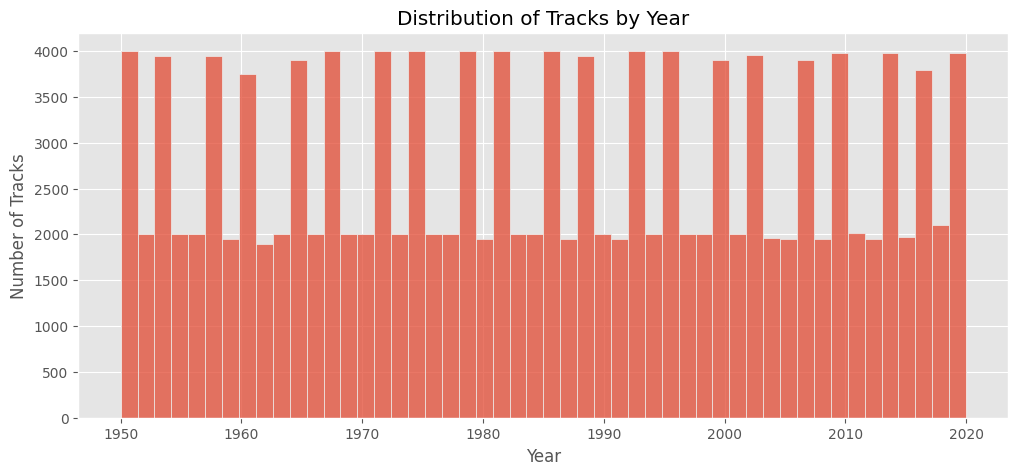

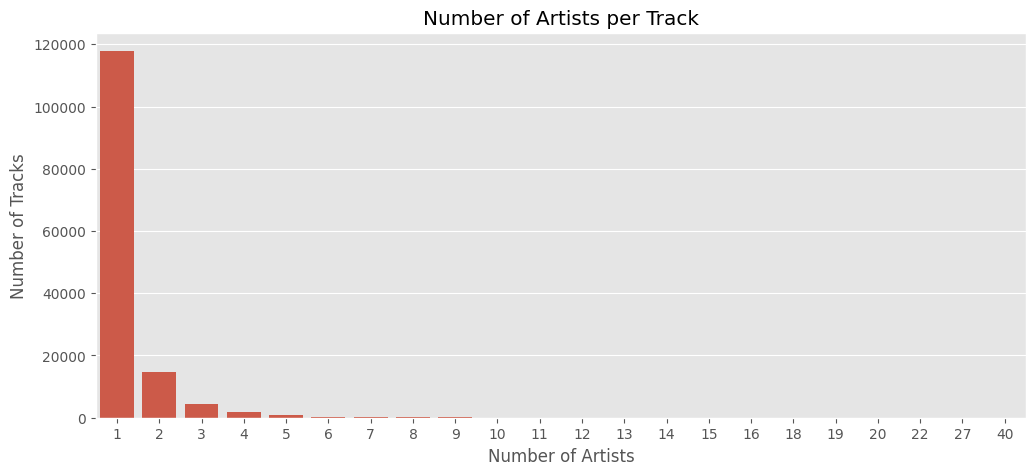

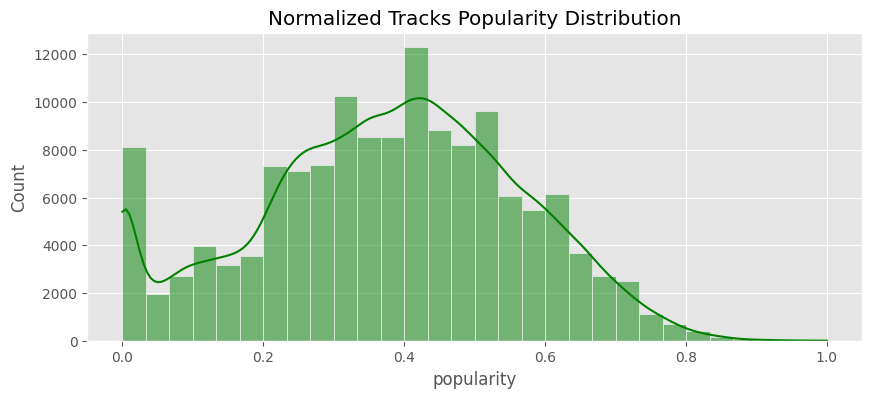

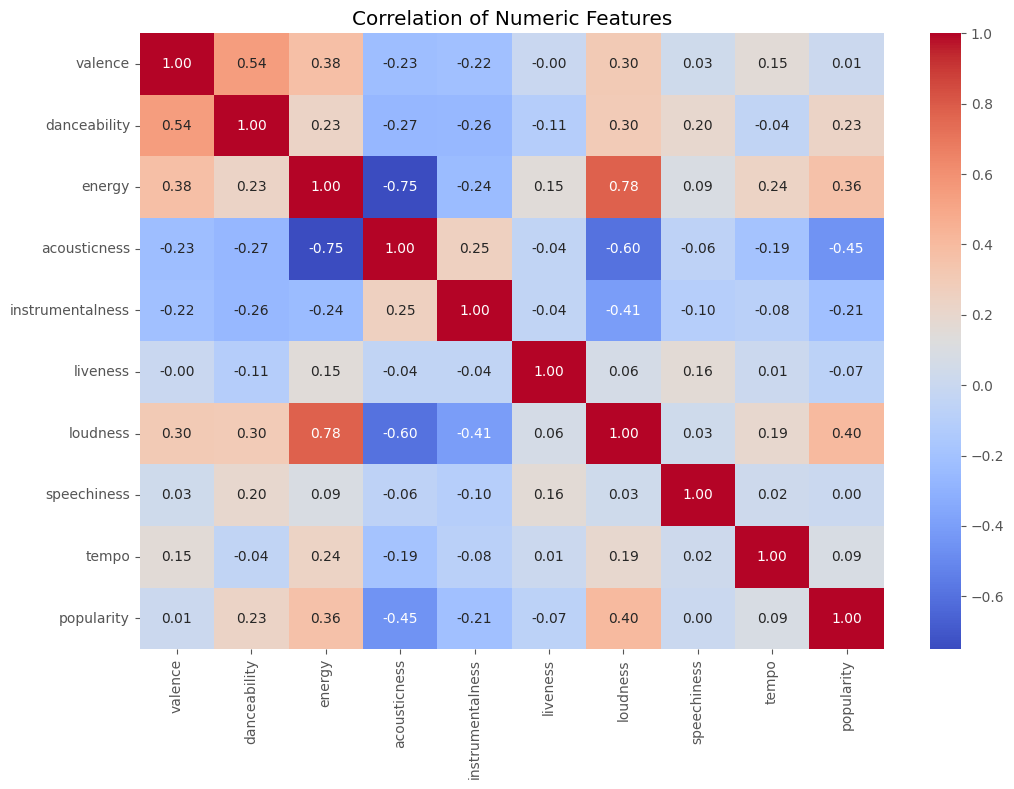

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_list,artists_joined,num_artists
5606,0.197,1950,0.993976,['Ella Fitzgerald'],0.358300,196667,0.0851,0,5RcvlmVx2xtFcp2Ta5pw7X,0.000004,...,0.725747,1,Someone To Watch Over Me,0.56,NaT,0.035604,0.401155,[Ella Fitzgerald],Ella Fitzgerald,1
5607,0.258,1950,0.989960,['Ella Fitzgerald'],0.460526,196440,0.1060,0,5DIVWgTeJ2fPIxaY9e7ZKn,0.000000,...,0.720287,1,I've Got A Crush On You,0.55,NaT,0.043550,0.274354,[Ella Fitzgerald],Ella Fitzgerald,1
5608,0.345,1950,0.963855,['Hoagy Carmichael'],0.665992,146347,0.0542,0,0VX8ptOQhUt1SIOHYLZGNN,0.106000,...,0.636499,1,Stardust,0.42,NaT,0.061507,0.370166,[Hoagy Carmichael],Hoagy Carmichael,1
5609,0.951,1950,0.833333,['Lefty Frizzell'],0.551619,179307,0.3920,0,3jvNwwHkWjELV3QALVz47D,0.000094,...,0.782960,1,If You've Got the Money I've Got the Time,0.43,1950-01-01,0.049639,0.855934,[Lefty Frizzell],Lefty Frizzell,1
5610,0.540,1950,0.961847,"['Dean Martin', 'Paul Weston And His Orchestra']",0.504049,155107,0.2210,0,7Eo3ow9Owy5iAoulBtE3Mq,0.053000,...,0.756934,0,Powder Your Face With Sunshine (Smile! Smile! ...,0.37,1950-01-01,0.046440,0.692990,"[Dean Martin, Paul Weston And His Orchestra]",Dean Martin | Paul Weston And His Orchestra,2


In [10]:
# ===============================================
# 3. Preprocess Tracks (data.csv)
# ===============================================

# --- Step 1: Convert 'artists' string → list + joined string ---
tracks['artists_list'] = tracks['artists'].apply(ast.literal_eval)
tracks['artists_joined'] = tracks['artists_list'].apply(lambda x: " | ".join(x))

# --- Step 2: Convert 'release_date' to datetime ---
tracks['release_date'] = pd.to_datetime(tracks['release_date'], errors='coerce')

# --- Step 3: Add 'num_artists' column ---
tracks['num_artists'] = tracks['artists_list'].apply(len)

# --- Step 4 (optional): filter modern tracks (year >= 1950) ---
tracks_modern = tracks[tracks['year'] >= 1950].copy()

# --- Step 5: Normalize numeric columns ---
from sklearn.preprocessing import MinMaxScaler

num_cols = ['valence','danceability','energy','acousticness','instrumentalness',
            'liveness','loudness','speechiness','tempo','popularity']

scaler = MinMaxScaler()
tracks_modern[num_cols] = scaler.fit_transform(tracks_modern[num_cols])

# --- Step 6: Check for duplicates by 'id' ---
print("Duplicate tracks by 'id':", tracks_modern.duplicated(subset=['id']).sum())

# --- Step 7: Visualizations ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

# Distribution of tracks per year
plt.figure(figsize=(12,5))
sns.histplot(tracks_modern['year'], bins=50, kde=False)
plt.title("Distribution of Tracks by Year")
plt.xlabel("Year")
plt.ylabel("Number of Tracks")
plt.show()

# Distribution of tracks by number of artists
plt.figure(figsize=(12,5))
sns.countplot(x=tracks_modern['num_artists'])
plt.title("Number of Artists per Track")
plt.xlabel("Number of Artists")
plt.ylabel("Number of Tracks")
plt.show()

# Popularity distribution
plt.figure(figsize=(10,4))
sns.histplot(tracks_modern['popularity'], bins=30, kde=True, color='green')
plt.title("Normalized Tracks Popularity Distribution")
plt.show()

# Correlation heatmap of numeric features
plt.figure(figsize=(12,8))
sns.heatmap(tracks_modern[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation of Numeric Features")
plt.show()

# --- Show preprocessed sample ---
tracks_modern.head()


In [11]:
# ==============================
# Verification for Tracks (data.csv)
# ==============================

# 1️⃣ Check for duplicate track IDs
dup_count = tracks['id'].duplicated().sum()
print(f"Duplicate tracks by 'id': {dup_count}")

# 2️⃣ Check missing release dates
missing_dates = tracks['release_date'].isnull().sum()
print(f"Missing release_date entries: {missing_dates}")

# 3️⃣ Verify numeric columns are within expected range (0-1)
num_cols = ['valence','danceability','energy','acousticness','instrumentalness',
            'liveness','loudness','speechiness','tempo','popularity']

out_of_bounds = ((tracks[num_cols] < 0) | (tracks[num_cols] > 1)).any().any()
print(f"Any numeric columns out of 0-1 range? {out_of_bounds}")

# 4️⃣ Check that all artists_list entries are lists
all_lists = tracks['artists_list'].apply(lambda x: isinstance(x, list)).all()
print(f"All entries in artists_list are lists? {all_lists}")

# 5️⃣ Check num_artists matches length of artists_list
num_artists_consistent = (tracks['num_artists'] == tracks['artists_list'].apply(len)).all()
print(f"num_artists consistent with artists_list? {num_artists_consistent}")


Duplicate tracks by 'id': 0
Missing release_date entries: 119798
Any numeric columns out of 0-1 range? True
All entries in artists_list are lists? True
num_artists consistent with artists_list? True


In [12]:
# Load by_artist CSV
by_artist = dfs['by_artist']

explore_csv(by_artist, name="Tracks by Artist (data_by_artist.csv)")


=== Tracks by Artist (data_by_artist.csv) SAMPLE ===


,mode,count,acousticness,artists,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,9,0.590111,"""Cats"" 1981 Original London Cast",0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5
1,1,26,0.862538,"""Cats"" 1983 Broadway Cast",0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5
2,1,7,0.856571,"""Fiddler On The Roof” Motion Picture Chorus",0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0
3,1,27,0.884926,"""Fiddler On The Roof” Motion Picture Orchestra",0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0
4,1,7,0.510714,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5



=== Tracks by Artist (data_by_artist.csv) INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28680 entries, 0 to 28679
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              28680 non-null  int64  
 1   count             28680 non-null  int64  
 2   acousticness      28680 non-null  float64
 3   artists           28680 non-null  object 
 4   danceability      28680 non-null  float64
 5   duration_ms       28680 non-null  float64
 6   energy            28680 non-null  float64
 7   instrumentalness  28680 non-null  float64
 8   liveness          28680 non-null  float64
 9   loudness          28680 non-null  float64
 10  speechiness       28680 non-null  float64
 11  tempo             28680 non-null  float64
 12  valence           28680 non-null  float64
 13  popularity        28680 non-null  float64
 14  key               28680 non-null  int64  
dtypes: float64(11), int64(3), object(1)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mode,28680.0,NaN,NaN,NaN,0.75917,0.427595,0.0,1.0,1.0,1.0,1.0
count,28680.0,NaN,NaN,NaN,13.847211,53.372544,1.0,2.0,3.0,8.0,3169.0
acousticness,28680.0,NaN,NaN,NaN,0.498373,0.370614,0.0,0.122296,0.478458,0.896,0.996
artists,28680,28680,조정현,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
danceability,28680.0,NaN,NaN,NaN,0.54649,0.176474,0.0,0.431,0.557,0.675,0.986
duration_ms,28680.0,NaN,NaN,NaN,238877.995213,121131.840422,18795.5,182330.40625,218640.0,268467.0,5403500.0
energy,28680.0,NaN,NaN,NaN,0.497488,0.254885,0.0,0.283568,0.504,0.702783,1.0
instrumentalness,28680.0,NaN,NaN,NaN,0.174756,0.298406,0.0,0.000004,0.00188,0.215291,1.0
liveness,28680.0,NaN,NaN,NaN,0.202441,0.140884,0.0,0.110362,0.161,0.247,0.991
loudness,28680.0,NaN,NaN,NaN,-11.140498,5.771749,-60.0,-13.972292,-10.088938,-6.889,1.342



=== Column Types ===
mode                  int64
count                 int64
acousticness        float64
artists              object
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
dtype: object

Unique values in 'mode': [1 0]

Unique values in 'key': [ 5  0  8 10  9  1  6  7  2  3  4 11]


In [13]:
# Copy for preprocessing
by_artist_modern = dfs['by_artist'].copy()

# --- Step 1: Check for duplicates ---
dup_count_artist = by_artist_modern.duplicated(subset=['artists']).sum()
print(f"Duplicate artists by 'artists': {dup_count_artist}")

# --- Step 2: Normalize numeric columns ---
from sklearn.preprocessing import MinMaxScaler

num_cols_artist = ['count', 'acousticness', 'danceability', 'duration_ms',
                   'energy', 'instrumentalness', 'liveness', 'loudness',
                   'speechiness', 'tempo', 'valence', 'popularity']

scaler_artist = MinMaxScaler()
by_artist_modern[num_cols_artist] = scaler_artist.fit_transform(by_artist_modern[num_cols_artist])


Duplicate artists by 'artists': 0


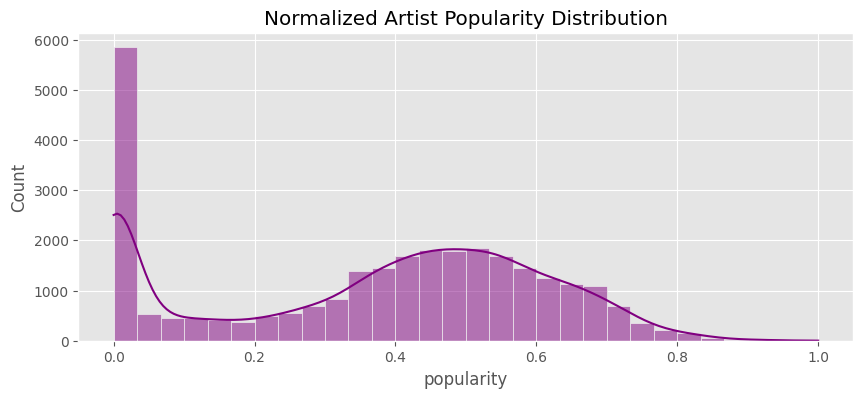

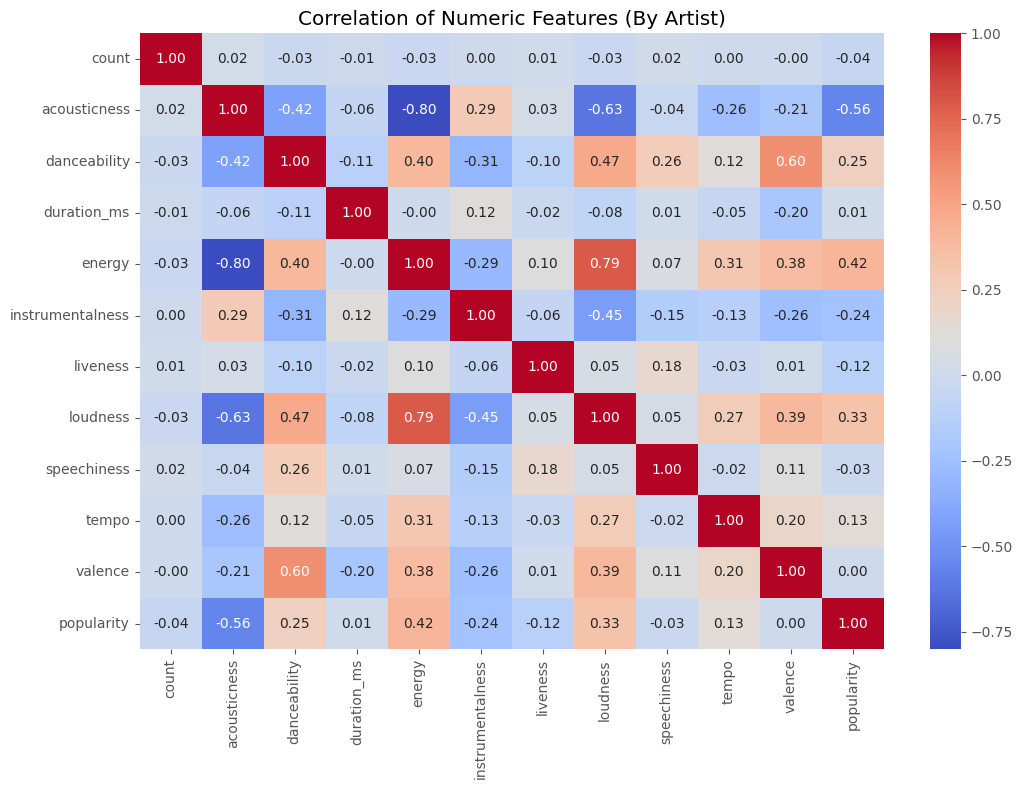

,mode,count,acousticness,artists,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,0.002525,0.592481,"""Cats"" 1981 Original London Cast",0.473856,0.042996,0.394003,0.011400,0.293475,0.742591,0.218246,0.539710,0.393037,0.412186,5
1,1,0.007891,0.866002,"""Cats"" 1983 Broadway Cast",0.448003,0.049861,0.406808,0.081158,0.318078,0.803854,0.182792,0.473238,0.271307,0.328784,5
2,1,0.001894,0.860011,"""Fiddler On The Roof” Motion Picture Chorus",0.353231,0.057594,0.286571,0.024593,0.328744,0.729831,0.122940,0.355354,0.358080,0.374808,0
3,1,0.008207,0.888480,"""Fiddler On The Roof” Motion Picture Orchestra",0.431110,0.045331,0.245770,0.073587,0.277983,0.723169,0.127801,0.407212,0.375408,0.374751,0
4,1,0.001894,0.512765,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.473776,0.046732,0.488286,0.009400,0.196771,0.811243,0.102223,0.564132,0.486666,0.462366,5


In [14]:
# --- Step 3: Visualizations ---
plt.style.use("ggplot")

# Popularity distribution
plt.figure(figsize=(10,4))
sns.histplot(by_artist_modern['popularity'], bins=30, kde=True, color='purple')
plt.title("Normalized Artist Popularity Distribution")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(by_artist_modern[num_cols_artist].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation of Numeric Features (By Artist)")
plt.show()

# --- Show sample ---
by_artist_modern.head()


In [15]:
# 1️⃣ Check duplicates
print("Duplicate artists:", by_artist_modern.duplicated(subset=['artists']).sum())

# 2️⃣ Check missing values
print("Missing values:\n", by_artist_modern.isnull().sum())

# 3️⃣ Check numeric columns within 0-1 range
out_of_bounds_artist = ((by_artist_modern[num_cols_artist] < 0) |
                        (by_artist_modern[num_cols_artist] > 1)).any().any()
print("Any numeric columns out of 0-1 range?", out_of_bounds_artist)

# 4️⃣ Ensure loudness and duration_ms make sense after normalization
by_artist_modern[['loudness', 'duration_ms']].agg(['min','max'])


Duplicate artists: 0
Missing values:
 mode                0
count               0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
key                 0
dtype: int64
Any numeric columns out of 0-1 range? True


,loudness,duration_ms
min,0.0,0.0
max,1.0,1.0


In [16]:
# ===============================================
# Load by_genres CSV
# ===============================================
by_genres = dfs['by_genres']

# Explore
explore_csv(by_genres, name="Tracks by Genres (data_by_genres.csv)")


=== Tracks by Genres (data_by_genres.csv) SAMPLE ===


,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.361600,-31.514333,0.040567,75.336500,0.103783,27.833333,6
1,1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.500000,5
2,1,8-bit,0.762000,0.712000,1.151770e+05,0.818000,0.876000,0.126000,-9.180000,0.047000,133.444000,0.975000,48.000000,7
3,1,[],0.651417,0.529093,2.328809e+05,0.419146,0.205309,0.218696,-12.288965,0.107872,112.857352,0.513604,20.859882,7
4,1,a cappella,0.676557,0.538961,1.906285e+05,0.316434,0.003003,0.172254,-12.479387,0.082851,112.110362,0.448249,45.820071,7



=== Tracks by Genres (data_by_genres.csv) INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB
None

=== Tracks by Genr

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mode,2973.0,NaN,NaN,NaN,0.833165,0.372891,0.0,1.0,1.0,1.0,1.0
genres,2973,2973,zydeco,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acousticness,2973.0,NaN,NaN,NaN,0.401241,0.31976,0.000003,0.11905,0.321745,0.673991,0.996
danceability,2973.0,NaN,NaN,NaN,0.537187,0.150668,0.0569,0.441202,0.546496,0.6475,0.929
duration_ms,2973.0,NaN,NaN,NaN,251720.854598,94656.856066,30946.0,206378.846154,237545.336064,277272.0,2382586.666667
energy,2973.0,NaN,NaN,NaN,0.561143,0.234486,0.001002,0.395058,0.601195,0.730127,0.994667
instrumentalness,2973.0,NaN,NaN,NaN,0.211366,0.267329,0.0,0.004835,0.0807,0.343333,0.992
liveness,2973.0,NaN,NaN,NaN,0.1928,0.092356,0.0222,0.137687,0.178764,0.220856,0.96
loudness,2973.0,NaN,NaN,NaN,-10.509848,5.369202,-41.825,-12.427656,-9.221817,-6.920125,0.06
speechiness,2973.0,NaN,NaN,NaN,0.083588,0.080483,0.0238,0.0449,0.059457,0.091,0.946219



=== Column Types ===
mode                  int64
genres               object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
dtype: object

Unique values in 'mode': [1 0]

Unique values in 'key': [ 6  5  7  1 10  2  9  4  0  8 11  3]


Duplicate genres by 'genres': 0


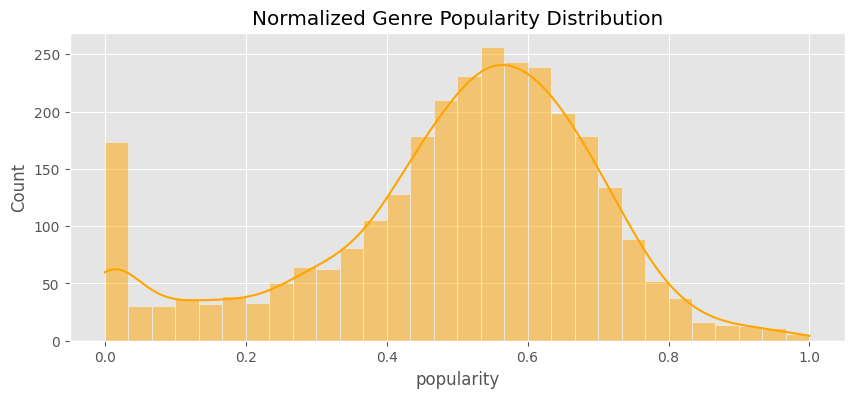

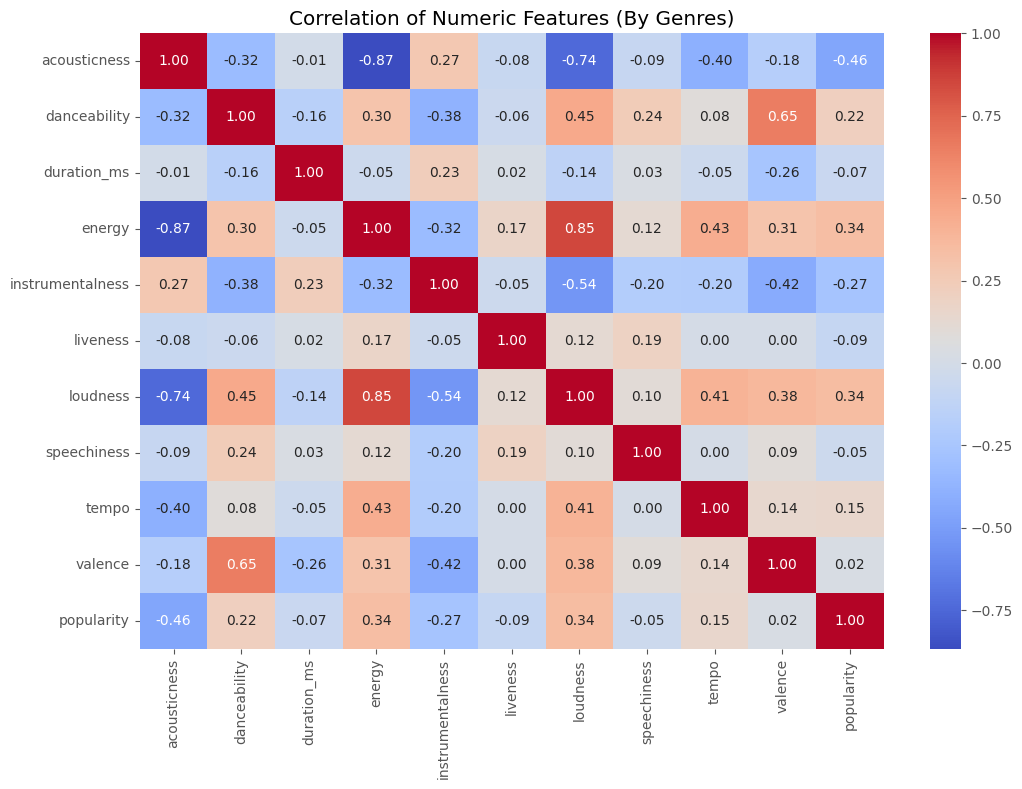

Duplicate genres: 0
Missing values:
 mode                0
genres              0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
key                 0
dtype: int64
Any numeric columns out of 0-1 range? False


In [17]:
# Copy for preprocessing
by_genres_modern = by_genres.copy()

# --- Step 1: Check for duplicates ---
dup_count_genres = by_genres_modern.duplicated(subset=['genres']).sum()
print(f"Duplicate genres by 'genres': {dup_count_genres}")

# --- Step 2: Normalize numeric columns ---
from sklearn.preprocessing import MinMaxScaler

num_cols_genres = ['acousticness', 'danceability', 'duration_ms',
                   'energy', 'instrumentalness', 'liveness', 'loudness',
                   'speechiness', 'tempo', 'valence', 'popularity']

scaler_genres = MinMaxScaler()
by_genres_modern[num_cols_genres] = scaler_genres.fit_transform(by_genres_modern[num_cols_genres])

# --- Step 3: Visualizations ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

# Popularity distribution
plt.figure(figsize=(10,4))
sns.histplot(by_genres_modern['popularity'], bins=30, kde=True, color='orange')
plt.title("Normalized Genre Popularity Distribution")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(by_genres_modern[num_cols_genres].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation of Numeric Features (By Genres)")
plt.show()

# --- Show sample ---
by_genres_modern.head()

# --- Verification ---
print("Duplicate genres:", by_genres_modern.duplicated(subset=['genres']).sum())
print("Missing values:\n", by_genres_modern.isnull().sum())
out_of_bounds_genres = ((by_genres_modern[num_cols_genres] < 0) |
                        (by_genres_modern[num_cols_genres] > 1)).any().any()
print("Any numeric columns out of 0-1 range?", out_of_bounds_genres)


In [18]:
# ===============================================
# Load by_year CSV
# ===============================================
by_year = dfs['by_year']

explore_csv(by_year, name="Tracks by Year (data_by_year.csv)")


=== Tracks by Year (data_by_year.csv) SAMPLE ===


,mode,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,1921,0.886896,0.418597,260537.166667,0.231815,0.344878,0.205710,-17.048667,0.073662,101.531493,0.379327,0.653333,2
1,1,1922,0.938592,0.482042,165469.746479,0.237815,0.434195,0.240720,-19.275282,0.116655,100.884521,0.535549,0.140845,10
2,1,1923,0.957247,0.577341,177942.362162,0.262406,0.371733,0.227462,-14.129211,0.093949,114.010730,0.625492,5.389189,0
3,1,1924,0.940200,0.549894,191046.707627,0.344347,0.581701,0.235219,-14.231343,0.092089,120.689572,0.663725,0.661017,10
4,1,1925,0.962607,0.573863,184986.924460,0.278594,0.418297,0.237668,-14.146414,0.111918,115.521921,0.621929,2.604317,5



=== Tracks by Year (data_by_year.csv) INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              100 non-null    int64  
 1   year              100 non-null    int64  
 2   acousticness      100 non-null    float64
 3   danceability      100 non-null    float64
 4   duration_ms       100 non-null    float64
 5   energy            100 non-null    float64
 6   instrumentalness  100 non-null    float64
 7   liveness          100 non-null    float64
 8   loudness          100 non-null    float64
 9   speechiness       100 non-null    float64
 10  tempo             100 non-null    float64
 11  valence           100 non-null    float64
 12  popularity        100 non-null    float64
 13  key               100 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 11.1 KB
None

=== Tracks by Year (data_by_year.csv) 

,count,mean,std,min,25%,50%,75%,max
mode,100.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
year,100.0,1970.500000,29.011492,1921.000000,1945.750000,1970.500000,1995.250000,2020.000000
acousticness,100.0,0.556317,0.275358,0.219931,0.289516,0.459190,0.856711,0.962607
danceability,100.0,0.536783,0.052356,0.414445,0.500800,0.540976,0.570948,0.692904
duration_ms,100.0,227296.752234,25630.048065,156881.657475,210889.193536,235520.850833,247702.738058,267677.823086
energy,100.0,0.452705,0.161738,0.207948,0.280733,0.495997,0.598008,0.681778
instrumentalness,100.0,0.193582,0.122488,0.016376,0.103323,0.127644,0.276707,0.581701
liveness,100.0,0.208224,0.017903,0.168450,0.197509,0.206074,0.218493,0.264335
loudness,100.0,-11.969054,3.105610,-19.275282,-14.189232,-11.773061,-9.950542,-6.595067
speechiness,100.0,0.105861,0.082128,0.049098,0.064244,0.085763,0.104438,0.490001



=== Column Types ===
mode                  int64
year                  int64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
dtype: object

Unique values in 'mode': [1]

Unique values in 'key': [ 2 10  0  5  9  7  1]


Duplicate entries by 'year': 0


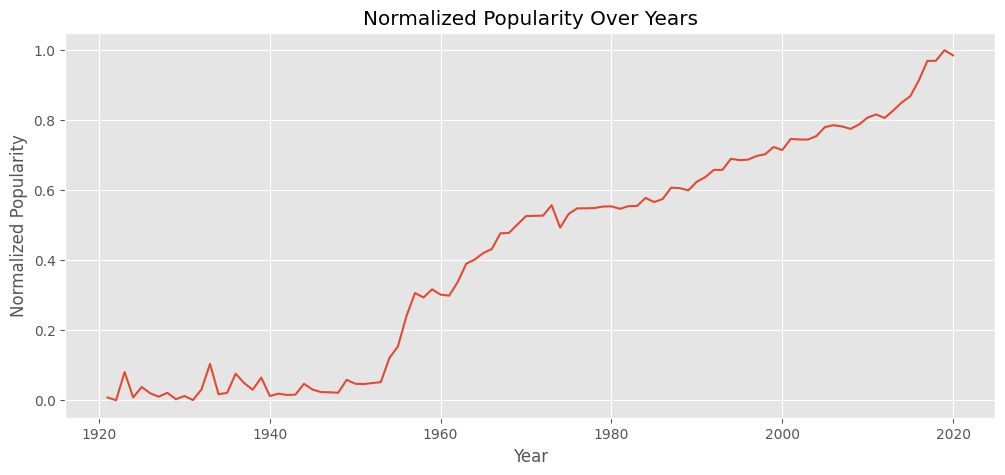

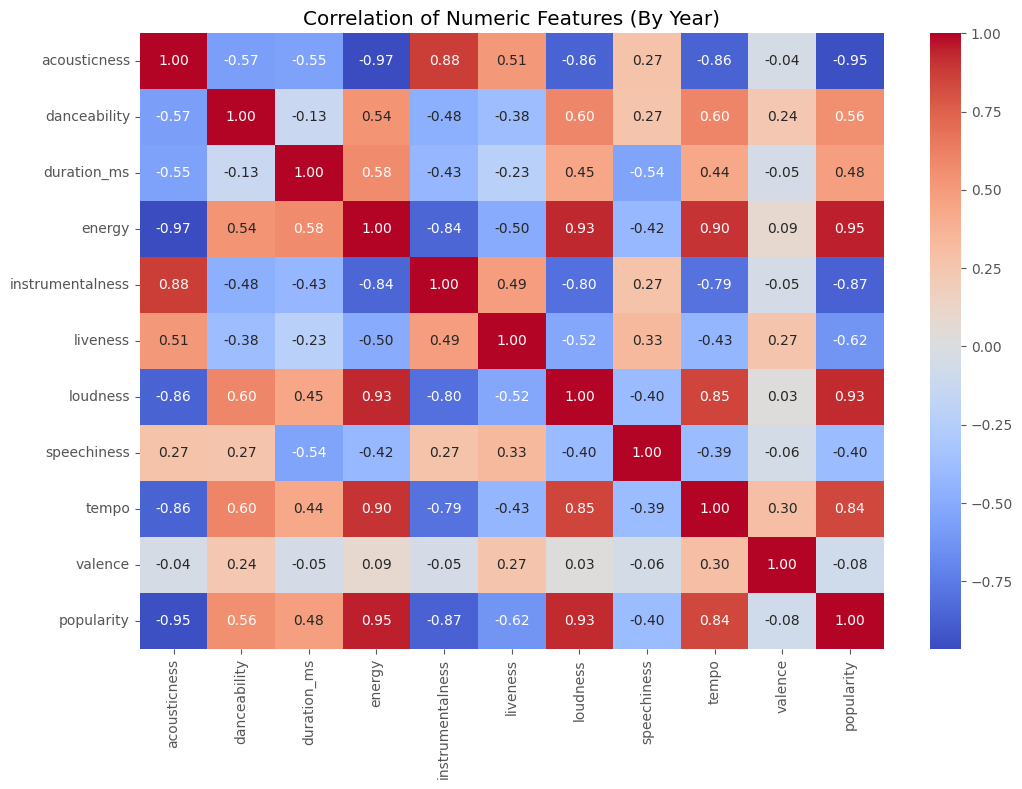

Duplicate years: 0
Missing values:
 mode                0
year                0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
key                 0
dtype: int64
Any numeric columns out of 0-1 range? True


,mode,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,1921,0.898056,0.014912,0.935551,0.050371,0.581086,0.388589,0.175598,0.055712,0.027650,0.000000,0.007870,2
1,1,1922,0.967664,0.242754,0.077513,0.063034,0.739078,0.753711,0.000000,0.153223,0.000000,0.549308,0.000000,10
2,1,1923,0.992783,0.584989,0.190085,0.114933,0.628589,0.615446,0.405835,0.101724,0.560982,0.865566,0.080600,0
3,1,1924,0.969829,0.486423,0.308359,0.287864,1.000000,0.696344,0.397780,0.097507,0.846420,1.000000,0.007988,10
4,1,1925,1.000000,0.572501,0.253666,0.149095,0.710957,0.721884,0.404478,0.142480,0.625567,0.853035,0.037832,5


In [19]:
# ===============================================
# Preprocess Tracks by Year
# ===============================================
by_year_modern = dfs['by_year'].copy()

# --- Step 1: Check duplicates by 'year' ---
dup_count_year = by_year_modern.duplicated(subset=['year']).sum()
print(f"Duplicate entries by 'year': {dup_count_year}")

# --- Step 2: Normalize numeric columns (excluding 'mode' and 'year') ---
num_cols_year = ['acousticness', 'danceability', 'duration_ms', 'energy',
                 'instrumentalness', 'liveness', 'loudness', 'speechiness',
                 'tempo', 'valence', 'popularity']

from sklearn.preprocessing import MinMaxScaler
scaler_year = MinMaxScaler()
by_year_modern[num_cols_year] = scaler_year.fit_transform(by_year_modern[num_cols_year])

# --- Step 3: Visualizations ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

# Popularity trend over years
plt.figure(figsize=(12,5))
sns.lineplot(x='year', y='popularity', data=by_year_modern)
plt.title("Normalized Popularity Over Years")
plt.xlabel("Year")
plt.ylabel("Normalized Popularity")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(by_year_modern[num_cols_year].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation of Numeric Features (By Year)")
plt.show()

# --- Step 4: Verification ---
print("Duplicate years:", by_year_modern.duplicated(subset=['year']).sum())
print("Missing values:\n", by_year_modern.isnull().sum())
out_of_bounds_year = ((by_year_modern[num_cols_year] < 0) |
                      (by_year_modern[num_cols_year] > 1)).any().any()
print("Any numeric columns out of 0-1 range?", out_of_bounds_year)

# Sample
by_year_modern.head()


In [20]:
# ===============================================
# Load and explore Tracks with Genres
# ===============================================
by_w_genres = dfs['w_genres'].copy()
explore_csv(by_w_genres, name="Tracks with Genres (data_w_genres.csv)")


=== Tracks with Genres (data_w_genres.csv) SAMPLE ===


,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7



=== Tracks with Genres (data_w_genres.csv) INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28680 entries, 0 to 28679
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            28680 non-null  object 
 1   artists           28680 non-null  object 
 2   acousticness      28680 non-null  float64
 3   danceability      28680 non-null  float64
 4   duration_ms       28680 non-null  float64
 5   energy            28680 non-null  float64
 6   instrumentalness  28680 non-null  float64
 7   liveness          28680 non-null  float64
 8   loudness          28680 non-null  float64
 9   speechiness       28680 non-null  float64
 10  tempo             28680 non-null  float64
 11  valence           28680 non-null  float64
 12  popularity        28680 non-null  float64
 13  key               28680 non-null  int64  
 14  mode              28680 non-null  int64  
 15  count             28680 non-null  

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
genres,28680,10743,[],9857,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artists,28680,28680,조정현,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acousticness,28680.0,NaN,NaN,NaN,0.498373,0.370614,0.0,0.122296,0.478458,0.896,0.996
danceability,28680.0,NaN,NaN,NaN,0.54649,0.176474,0.0,0.431,0.557,0.675,0.986
duration_ms,28680.0,NaN,NaN,NaN,238877.995213,121131.840422,18795.5,182330.40625,218640.0,268467.0,5403500.0
energy,28680.0,NaN,NaN,NaN,0.497488,0.254885,0.0,0.283568,0.504,0.702783,1.0
instrumentalness,28680.0,NaN,NaN,NaN,0.174756,0.298406,0.0,0.000004,0.00188,0.215291,1.0
liveness,28680.0,NaN,NaN,NaN,0.202441,0.140884,0.0,0.110362,0.161,0.247,0.991
loudness,28680.0,NaN,NaN,NaN,-11.140498,5.771749,-60.0,-13.972292,-10.088938,-6.889,1.342
speechiness,28680.0,NaN,NaN,NaN,0.094014,0.111986,0.0,0.0392,0.0522,0.0953,0.964



=== Column Types ===
genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

Unique values in 'key': [ 5  0  8 10  9  1  6  7  2  3  4 11]

Unique values in 'mode': [1 0]


Missing values:
 genres              0
artists             0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
key                 0
mode                0
count               0
genres_list         0
num_genres          0
dtype: int64
Any numeric columns out of 0-1 range? True


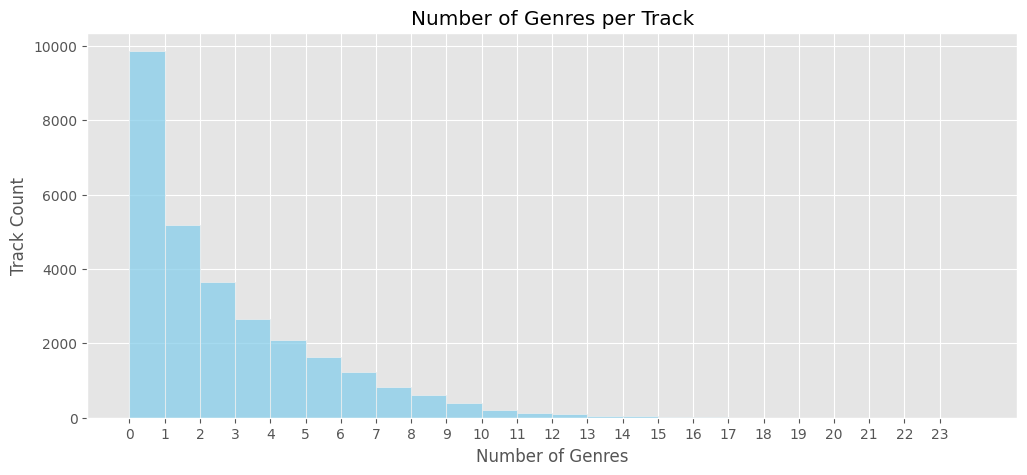

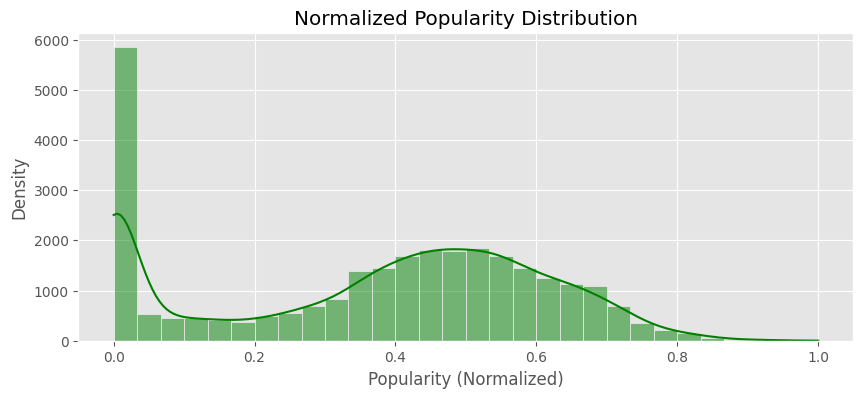

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres_list,num_genres
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.592481,0.473856,0.042996,0.394003,0.011400,0.293475,0.742591,0.218246,0.539710,0.393037,0.412186,5,1,9,[show tunes],1
1,[],"""Cats"" 1983 Broadway Cast",0.866002,0.448003,0.049861,0.406808,0.081158,0.318078,0.803854,0.182792,0.473238,0.271307,0.328784,5,1,26,[],0
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.860011,0.353231,0.057594,0.286571,0.024593,0.328744,0.729831,0.122940,0.355354,0.358080,0.374808,0,1,7,[],0
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.888480,0.431110,0.045331,0.245770,0.073587,0.277983,0.723169,0.127801,0.407212,0.375408,0.374751,0,1,27,[],0
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.512765,0.473776,0.046732,0.488286,0.009400,0.196771,0.811243,0.102223,0.564132,0.486666,0.462366,5,1,7,[],0


In [21]:
# --- Step 0: Copy for preprocessing ---
w_genres_modern = dfs['w_genres'].copy()

# --- Step 1: Convert 'genres' strings to lists ---
w_genres_modern['genres_list'] = w_genres_modern['genres'].apply(
    lambda x: ast.literal_eval(x) if x not in [None, ''] else []
)

# --- Step 2: Number of genres per track ---
w_genres_modern['num_genres'] = w_genres_modern['genres_list'].apply(len)

# --- Step 3: Normalize numeric columns ---
num_cols_w_genres = ['acousticness', 'danceability', 'duration_ms', 'energy',
                     'instrumentalness', 'liveness', 'loudness', 'speechiness',
                     'tempo', 'valence', 'popularity']

scaler_w_genres = MinMaxScaler()
w_genres_modern[num_cols_w_genres] = scaler_w_genres.fit_transform(w_genres_modern[num_cols_w_genres])

# --- Step 4: Quick checks ---
print("Missing values:\n", w_genres_modern.isnull().sum())
print("Any numeric columns out of 0-1 range?",
      ((w_genres_modern[num_cols_w_genres] < 0) |
       (w_genres_modern[num_cols_w_genres] > 1)).any().any())

# --- Step 5: Visualizations ---
# Number of genres per track
plt.figure(figsize=(12,5))
sns.histplot(w_genres_modern['num_genres'],
             bins=range(0, w_genres_modern['num_genres'].max()+2),
             color='skyblue', kde=False)
plt.title("Number of Genres per Track")
plt.xlabel("Number of Genres")
plt.ylabel("Track Count")
plt.xticks(range(0, w_genres_modern['num_genres'].max()+1))
plt.show()

# Popularity distribution
plt.figure(figsize=(10,4))
sns.histplot(w_genres_modern['popularity'], bins=30, kde=True, color='green')
plt.title("Normalized Popularity Distribution")
plt.xlabel("Popularity (Normalized)")
plt.ylabel("Density")
plt.show()

# --- Show sample ---
w_genres_modern.head()

In [22]:
print("Tracks columns:", tracks_modern.columns.tolist())
print("By Artist columns:", by_artist_modern.columns.tolist())
print("By Genres columns:", by_genres_modern.columns.tolist())
print("By Year columns:", by_year_modern.columns.tolist())
print("Tracks with Genres columns:", w_genres_modern.columns.tolist())


Tracks columns: ['valence', 'year', 'acousticness', 'artists', 'danceability', 'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo', 'artists_list', 'artists_joined', 'num_artists']
By Artist columns: ['mode', 'count', 'acousticness', 'artists', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'key']
By Genres columns: ['mode', 'genres', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'key']
By Year columns: ['mode', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'key']
Tracks with Genres columns: ['genres', 'artists', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumen

In [23]:
# ===============================
# 1. Load pre-trained embedding model
# ===============================
model = SentenceTransformer('all-MiniLM-L6-v2')

# ===============================
# 2. Create meaningful text columns for embeddings
# ===============================

def create_text_column(df, category):
    if category == 'tracks':
        df['text'] = df['name'].fillna('') + " | " + df['artists_joined'].fillna('')
    elif category == 'by_artist':
        df['text'] = df['artists'].astype(str)
    elif category == 'by_genres':
        df['text'] = df['genres'].astype(str)
    elif category == 'by_year':
        # Make each row a real song for embedding
        if 'name' in df.columns and 'artists' in df.columns:
            df['text'] = df['name'].fillna('') + " | " + df['artists'].astype(str) + " | " + df['year'].astype(str)
        else:
            df['text'] = df['year'].astype(str)
    elif category == 'w_genres':
        df['text'] = df['artists'].astype(str) + " | " + df['genres_list'].astype(str)
    else:
        df['text'] = df.columns[0].astype(str)
    return df

# Apply to datasets
tracks_modern = create_text_column(tracks_modern, 'tracks')
by_artist_modern = create_text_column(by_artist_modern, 'by_artist')
by_genres_modern = create_text_column(by_genres_modern, 'by_genres')
by_year_modern = create_text_column(by_year_modern, 'by_year')
w_genres_modern = create_text_column(w_genres_modern, 'w_genres')

# ===============================
# 3. Create embeddings
# ===============================
def create_embeddings(df):
    texts = df['text'].astype(str).tolist()
    return model.encode(texts, show_progress_bar=True)

print("Creating embeddings for tracks...")
tracks_embeddings = create_embeddings(tracks_modern)
print("Creating embeddings for by_artist...")
artist_embeddings = create_embeddings(by_artist_modern)
print("Creating embeddings for by_genres...")
genres_embeddings = create_embeddings(by_genres_modern)
print("Creating embeddings for by_year...")
year_embeddings = create_embeddings(by_year_modern)
print("Creating embeddings for w_genres...")
w_genres_embeddings = create_embeddings(w_genres_modern)
print("✅ All embeddings created successfully!")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Creating embeddings for tracks...


Batches:   0%|          | 0/4394 [00:00<?, ?it/s]

Creating embeddings for by_artist...


Batches:   0%|          | 0/897 [00:00<?, ?it/s]

Creating embeddings for by_genres...


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Creating embeddings for by_year...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Creating embeddings for w_genres...


Batches:   0%|          | 0/897 [00:00<?, ?it/s]

✅ All embeddings created successfully!


In [24]:
import faiss, math, random
from sklearn.preprocessing import normalize
from IPython.display import HTML, display
import ipywidgets as widgets
import numpy as np
import pandas as pd

# --- Basic safety / alignment checks ---
# Ensure the tracks_modern DataFrame and tracks_embeddings exist
assert 'tracks_modern' in globals(), "tracks_modern not found in environment"
assert 'tracks_embeddings' in globals(), "tracks_embeddings not found in environment"

# Make sure text column exists (you created it earlier); fallback to name|artists_joined
if 'text' not in tracks_modern.columns:
    tracks_modern['text'] = tracks_modern['name'].fillna('') + " | " + tracks_modern['artists_joined'].fillna('')

# Add cover_url placeholder (optional)
if 'cover_url' not in tracks_modern.columns:
    tracks_modern['cover_url'] = ''

# Convert the embeddings list -> numpy float32 and normalize
emb = np.array(tracks_embeddings, dtype='float32')
emb_normalized = normalize(emb, axis=1)  # required for cosine via inner product
d = emb_normalized.shape[1]

# Build or reuse FAISS index (inner product on normalized vectors = cosine)
index = faiss.IndexFlatIP(d)
index.add(emb_normalized)
print(f"FAISS index built: {index.ntotal} vectors, dim={d}")

# Create mapping from track id (string) to positional index used by embeddings
index_to_id = tracks_modern['id'].astype(str).tolist()
id_to_index = {id_str: pos for pos, id_str in enumerate(index_to_id)}

# --- Choose audio numeric columns using the columns you provided ---
possible_audio_cols = ['valence','danceability','energy','acousticness','instrumentalness',
                       'liveness','loudness','speechiness','tempo','popularity','duration_ms']
audio_num_cols = [c for c in possible_audio_cols if c in tracks_modern.columns]
print("Audio numeric columns used for audio similarity:", audio_num_cols)

# Prepare audio feature matrix and normalize rows to unit vectors for cosine
audio_features = tracks_modern[audio_num_cols].fillna(0).values.astype('float32')
audio_features_norm = normalize(audio_features, axis=1)

# ---------- Core hybrid recommender ----------
def recommend_by_track(track_query=None, track_id=None, top_k=15,
                       weight_embed=0.9, weight_audio=0.1, exclude_self=True):
    if track_id is None and (track_query is None or track_query.strip()==''):
        raise ValueError("Provide either track_id or a non-empty track_query")

    # Resolve seed index (positional index that matches embeddings)
    if track_id is not None:
        key = str(track_id)
        if key not in id_to_index:
            # fallback: try to locate in DataFrame then map to position
            matches = tracks_modern.index[tracks_modern['id'].astype(str) == key].tolist()
            if not matches:
                raise ValueError(f"track_id {track_id} not found")
            seed_pos = int(matches[0])  # DataFrame index should align to embedding order if unchanged
        else:
            seed_pos = id_to_index[key]
    else:
        q = track_query.strip().lower()
        # quick substring match in text column
        matches = tracks_modern[tracks_modern['text'].str.lower().str.contains(q)]
        if not matches.empty:
            # pick the top popularity match among substrings
            chosen_idx = matches.sort_values('popularity', ascending=False).index[0]
            seed_pos = int(chosen_idx)
        else:
            # fallback to embedding query nearest neighbor
            q_emb = model.encode([track_query])
            q_emb = normalize(np.array(q_emb, dtype='float32'), axis=1)
            Dq, Iq = index.search(q_emb, 1)
            seed_pos = int(Iq[0][0])

    # seed vectors
    seed_emb = emb_normalized[seed_pos:seed_pos+1]
    seed_audio = audio_features_norm[seed_pos:seed_pos+1]

    # embedding-based nearest neighbors (fast)
    num_candidates = min(top_k*5, len(tracks_modern))  # find extra candidates to re-rank by hybrid score
    D_emb, I_emb = index.search(seed_emb, num_candidates + (1 if exclude_self else 0))
    emb_scores = D_emb[0]
    emb_indices = I_emb[0].tolist()

    # audio similarity global
    audio_sim = np.dot(audio_features_norm, seed_audio.T).squeeze()

    # Merge candidates and compute combined score
    rows = []
    seen = set()
    for idx, e_score in zip(emb_indices, emb_scores):
        if exclude_self and idx == seed_pos:
            continue
        if idx in seen:
            continue
        seen.add(idx)
        a_score = float(audio_sim[idx])
        combined = weight_embed * float(e_score) + weight_audio * a_score
        rows.append((idx, float(e_score), a_score, float(combined)))
    # If not enough results, fall back on best audio-similar tracks too
    if len(rows) < top_k:
        top_audio_idx = np.argsort(audio_sim)[::-1]
        for idx in top_audio_idx:
            if exclude_self and idx == seed_pos:
                continue
            if idx in seen:
                continue
            e_score = float(np.dot(emb_normalized[idx:idx+1], seed_emb.T).squeeze())
            a_score = float(audio_sim[idx])
            combined = weight_embed * e_score + weight_audio * a_score
            rows.append((int(idx), e_score, a_score, float(combined)))
            seen.add(int(idx))
            if len(rows) >= top_k:
                break

    rows_sorted = sorted(rows, key=lambda x: x[3], reverse=True)[:top_k]

    recs = []
    for idx, emb_s, audio_s, comb_s in rows_sorted:
        meta = tracks_modern.iloc[idx].to_dict()
        recs.append({
            'id': meta.get('id'),
            'name': meta.get('name'),
            'artists': meta.get('artists_joined'),
            'year': meta.get('year'),
            'popularity': meta.get('popularity'),
            'emb_score': emb_s,
            'audio_score': audio_s,
            'score': comb_s,
            'cover_url': meta.get('cover_url','')
        })
    return pd.DataFrame(recs)

# ---------- Additional helpers ----------
def recommend_by_artist(artist_name, top_k_per_seed=3, overall_top_k=20, **kwargs):
    cand = tracks_modern[tracks_modern['artists_joined'].str.lower().str.contains(artist_name.lower())]
    if cand.empty:
        raise ValueError("No tracks found for that artist")
    seeds = cand.sort_values('popularity', ascending=False).head(top_k_per_seed)
    all_recs = []
    for idx in seeds.index:
        recs = recommend_by_track(track_id=str(tracks_modern.loc[idx,'id']), top_k=overall_top_k, **kwargs)
        all_recs.append(recs)
    if not all_recs:
        return pd.DataFrame()
    df = pd.concat(all_recs).drop_duplicates('id').sort_values('score', ascending=False).head(overall_top_k)
    return df

def recommend_by_genre(genre_query, top_k=20, **kwargs):
    # rely on your w_genres / genres_list if available, else try substring of 'text' or 'artists'
    if 'genres_list' in tracks_modern.columns:
        cand = tracks_modern[tracks_modern['genres_list'].apply(lambda x: genre_query.lower() in str(x).lower())]
    elif 'genres' in tracks_modern.columns:
        cand = tracks_modern[tracks_modern['genres'].str.lower().str.contains(genre_query.lower(), na=False)]
    else:
        # fallback: search text
        cand = tracks_modern[tracks_modern['text'].str.lower().str.contains(genre_query.lower(), na=False)]
    if cand.empty:
        raise ValueError("No tracks found for that genre query")
    # choose a random seed from candidate pool (or top popularity)
    seed_idx = int(cand.sort_values('popularity', ascending=False).index[0])
    return recommend_by_track(track_id=str(tracks_modern.loc[seed_idx,'id']), top_k=top_k, **kwargs)

def recommend_by_year(year_value, top_k=20, **kwargs):
    if 'year' not in tracks_modern.columns:
        raise ValueError("No 'year' column in tracks_modern")
    cand = tracks_modern[tracks_modern['year'] == int(year_value)]
    if cand.empty:
        raise ValueError(f"No tracks found for year {year_value}")
    seed_idx = int(cand.sort_values('popularity', ascending=False).index[0])
    return recommend_by_track(track_id=str(tracks_modern.loc[seed_idx,'id']), top_k=top_k, **kwargs)

# ---------- Small UI (re-use earlier UI idea) ----------
def thumbnail_html(url, size=64):
    if not url or str(url).strip()=='':
        return ""
    return f'<img src="{url}" width="{size}" height="{size}" style="object-fit:cover;border-radius:4px;margin-right:6px;">'

def display_recommendations(df, max_rows=10):
    html_rows = []
    for _, r in df.head(max_rows).iterrows():
        img = thumbnail_html(r.get('cover_url',''), size=64)
        title = f"<b>{r['name']}</b> — {r['artists']}"
        meta = f"Year: {r.get('year','')} • popularity: {r.get('popularity','')}"
        scores = f"score: {r['score']:.4f} (emb: {r['emb_score']:.3f}, audio: {r['audio_score']:.3f})"
        html_rows.append(f"<div style='display:flex;align-items:center;margin:6px 0'>{img}<div>{title}<br><small style='color:gray'>{meta}<br>{scores}</small></div></div>")
    display(HTML("<div>" + "\n".join(html_rows) + "</div>"))

# Simple example usage prints to confirm working
print("\nTest: top 5 recommendations for a seed substring 'love' (if exists):")
try:
    sample_recs = recommend_by_track(track_query='love', top_k=5)
    display_recommendations(sample_recs, max_rows=5)
    display(sample_recs[['id','name','artists','year','popularity','score']])
except Exception as e:
    print("No sample recs (OK if dataset has no matching 'love') ->", e)

print("\nFunctions available: recommend_by_track, recommend_by_artist, recommend_by_genre, recommend_by_year")


FAISS index built: 140600 vectors, dim=384
Audio numeric columns used for audio similarity: ['valence', 'danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'popularity', 'duration_ms']

Test: top 5 recommendations for a seed substring 'love' (if exists):


,id,name,artists,year,popularity,score
0,2XjATPzicorHx6W0vjOpWf,Jody's Got Your Girl And Gone,Johnnie Taylor,1970,0.26,1.000000
1,3gyvHQCFOlUAtHUkXR0gOQ,Cheaper To Keep Her,Johnnie Taylor,1973,0.29,0.671620
2,4swwucP2GWoqEAvQcm7vgT,Johnny Get Your Girl,Dean Martin,1950,0.17,0.653279
3,4UOnJkBDe8FehpZMMJYgdN,My Man's Gone Now,Ella Fitzgerald,1958,0.27,0.645699
4,6KmnejQFYdWUVUJh6zwEce,I Found a Love,Johnnie Taylor,1988,0.32,0.639240



Functions available: recommend_by_track, recommend_by_artist, recommend_by_genre, recommend_by_year


In [25]:
recs = recommend_by_artist("justin bieber", overall_top_k=10)
display_recommendations(recs)

In [26]:
# Save preprocessed dataframe
tracks_modern.to_csv("tracks_modern.csv", index=False)

# Save embeddings
np.save("tracks_embeddings.npy", tracks_embeddings)

# Save FAISS index
faiss.write_index(index, "faiss_index.bin")


In [27]:
!zip -r all-MiniLM-L6-v2.zip /root/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2


  adding: root/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/ (stored 0%)
  adding: root/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/ (stored 0%)
  adding: root/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/ (stored 0%)
  adding: root/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/README.md (deflated 64%)
  adding: root/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/sentence_bert_config.json (deflated 4%)
  adding: root/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/special_tokens_map.json (deflated 40%)
  adding: root/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d